<a href="https://colab.research.google.com/github/JADESOLA-O/Facial-Emotion-Recognition-Using-Convolutional-Neural-Network/blob/main/FER_Models_JADES_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Facial Emotion Recognition Using Convolutional Neural Network
Facial emotion recognition systems are used in a wide range of industries. In healthcare, FER can be integrated into monitoring systems to assess patients’ emotional states, which is particularly useful for mental health applications where real-time monitoring can alert caregivers to early signs of distress. Customer analytics in retail environments can utilize FER to gauge customer satisfaction, providing insights for tailored customer service. In security, FER can analyze behaviours in real-time, potentially flagging suspicious activities based on unusual emotional states.

The primary goal is to identify the best-performing CNN model for real-time facial emotion recognition and integrate this model into a web application that can detect emotions accurately and efficiently.
The secondary goals of the project are to design a system that excels in training unseen and real-world data, ensuring its practical usefulness. The project also aims to construct an efficient system that can be directly employed in real-time applications. This study would create a practical FER system for deployment in diverse applications by exploring and combining advanced CNN architectures with data augmentation and real-time processing techniques.

#Importing Neccessary Libriaries

In [ ]:
!nvidia-smi

Sat Aug 10 15:45:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [ ]:
# Import necessary packages.
import numpy as np
from PIL import Image
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torchvision.models as models
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms
import torch.nn.functional as F
from flask import Flask, render_template, Response
import cv2
import os
import streamlit as st
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import label_binarize


# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

In [ ]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset/') # insert ypu kaggle username and key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: idowujadesola
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset


100%|██████████| 37.7M/37.7M [00:00<00:00, 53.3MB/s]


#Setting Parameters

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Parameters
batch_size = 32
n_epochs = 100
patience = 5

# Define transforms with enhanced data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

#Loading Dataset

In [ ]:

# Load datasets
data_dir = './raf-db-dataset/DATASET'
# Construct datasets
full_dataset = datasets.ImageFolder("raf-db-dataset/DATASET/train", transform=train_transform)
test_dataset = datasets.ImageFolder("raf-db-dataset/DATASET/test", transform=test_transform)


#Splitting dataset into three subset (train, test, validation)

In [ ]:
# Split the dataset into train and validation
train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
val_size = len(full_dataset) - train_size

train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Define train and validation split
train_ratio = 0.8
val_ratio = 1 - train_ratio

train_size = int(train_ratio * len(full_dataset))
val_size = len(full_dataset) - train_size

train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

print(f'Original train set has {len(full_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')


Original train set has 12271 samples
Train set has 9816 samples
Validation set has 2455 samples
Test set has 3068 samples


In [ ]:
# Create DataLoaders for train, validation, and test sets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
valid_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

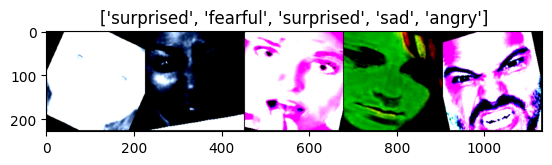

In [ ]:
# Show some samples of images in the dataset
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

out = torchvision.utils.make_grid(inputs)
class_names = ['surprised', 'fearful', 'disgusted', 'happy', 'sad', 'angry', 'neutral']

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#RESNET50
Training resnet50 model

In [ ]:
# Define the Pretrained ResNet50 Model
class PretrainedResNet50(nn.Module):
    def __init__(self, num_classes=7):
        super(PretrainedResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
# Initialize model, criterion, optimizer, and scheduler
model = PretrainedResNet50(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.8MB/s]


In [ ]:
# Training loop with early stopping
best_valid_acc = 0
epochs_no_improve = 0
early_stop = False

train_loss_history = []
train_acc_history = []
valid_loss_history = []
valid_acc_history = []

for epoch in range(n_epochs):
    if early_stop:
        print("Early stopping")
        break

    model.train()
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    model.eval()
    valid_loss = []
    valid_accs = []

    with torch.no_grad():
        for batch in tqdm(valid_loader):
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)

            acc = (logits.argmax(dim=-1) == labels).float().mean()
            valid_loss.append(loss.item())
            valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)

    # Step the scheduler
    scheduler.step(valid_loss)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_resnet50_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        early_stop = True

    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

# Load the best model
model.load_state_dict(torch.load('best_resnet50_model.pth'))


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 001/100] Train: loss=1.09051, acc=0.61078 | Valid: loss=0.83411, acc=0.69426


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 002/100] Train: loss=0.77462, acc=0.72883 | Valid: loss=0.75407, acc=0.73013


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 003/100] Train: loss=0.66117, acc=0.76137 | Valid: loss=0.66188, acc=0.76567


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 004/100] Train: loss=0.61076, acc=0.78349 | Valid: loss=0.64839, acc=0.77525


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 005/100] Train: loss=0.54506, acc=0.80615 | Valid: loss=0.61698, acc=0.78337


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 006/100] Train: loss=0.51888, acc=0.81304 | Valid: loss=0.65586, acc=0.76706


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 007/100] Train: loss=0.49276, acc=0.82468 | Valid: loss=0.62549, acc=0.78930


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 008/100] Train: loss=0.45293, acc=0.83954 | Valid: loss=0.57409, acc=0.81015


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 009/100] Train: loss=0.42007, acc=0.85155 | Valid: loss=0.59260, acc=0.79117


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 010/100] Train: loss=0.42306, acc=0.84867 | Valid: loss=0.60891, acc=0.78914


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 011/100] Train: loss=0.37725, acc=0.86703 | Valid: loss=0.57911, acc=0.80788


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 012/100] Train: loss=0.36356, acc=0.87052 | Valid: loss=0.61104, acc=0.79611


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 013/100] Train: loss=0.34459, acc=0.87771 | Valid: loss=0.58860, acc=0.80707
Early stopping


<All keys matched successfully>

In [ ]:
# Evaluate on the test set
model.eval()
test_loss = []
test_accs = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        loss = criterion(logits, labels)

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        test_loss.append(loss.item())
        test_accs.append(acc.item())

test_loss = sum(test_loss) / len(test_loss)
test_acc = sum(test_accs) / len(test_accs)

print(f"Test: loss={test_loss:.5f}, acc={test_acc:.5f}")

  0%|          | 0/96 [00:00<?, ?it/s]

Test: loss=0.51572, acc=0.81980


Test score is 82%

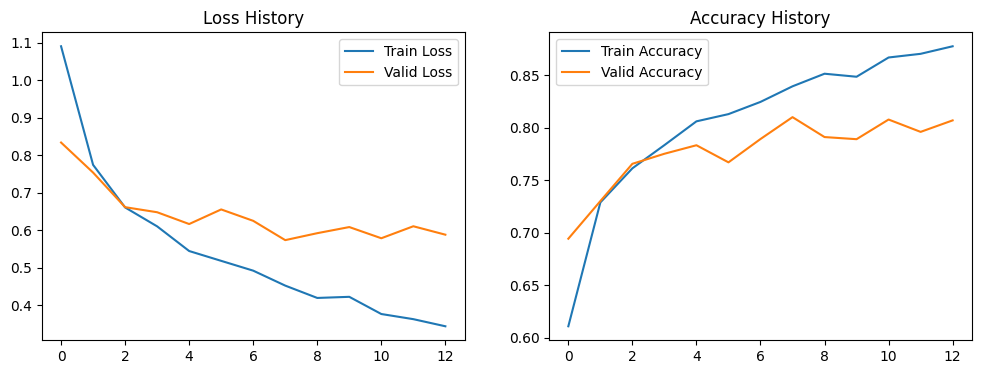

In [ ]:
# Plotting training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Valid Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(valid_acc_history, label='Valid Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.show()

In [ ]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

def test_model(model, test_loader, classes):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


#Resnet classification report

In [ ]:
# Generate predictions and true labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        predictions = logits.argmax(dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

  0%|          | 0/96 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

   surprised       0.86      0.78      0.82       329
     fearful       0.67      0.55      0.61        74
   disgusted       0.49      0.46      0.47       160
       happy       0.94      0.90      0.92      1185
         sad       0.80      0.79      0.80       478
       angry       0.71      0.78      0.74       162
     neutral       0.74      0.85      0.79       680

    accuracy                           0.82      3068
   macro avg       0.75      0.73      0.74      3068
weighted avg       0.82      0.82      0.82      3068



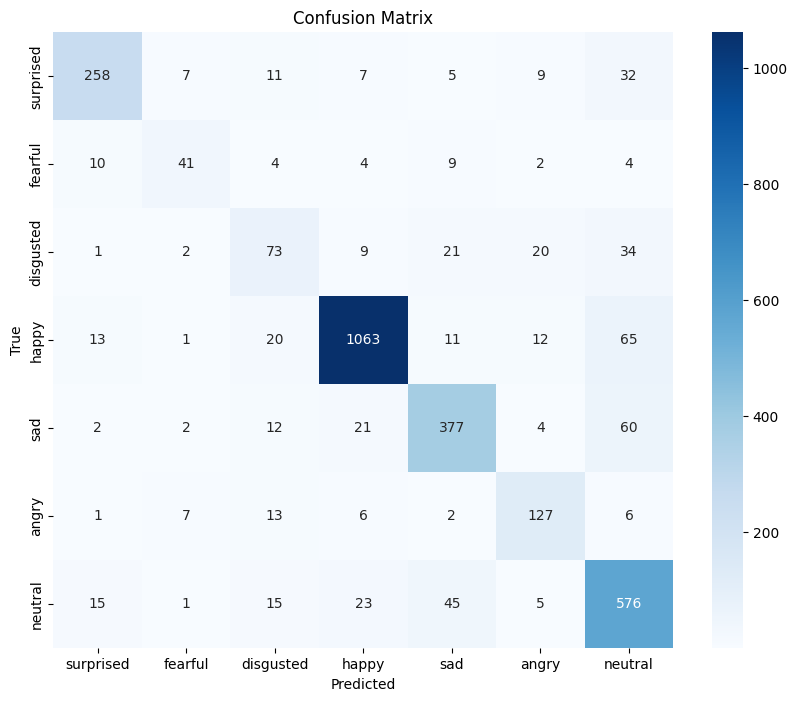

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Initialize lists to store true labels and predicted probabilities
y_true = []
y_pred_proba = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)  # Get probabilities using softmax
        y_true.extend(labels.cpu().numpy())
        y_pred_proba.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Binarize the true labels for AUC computation
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

# Calculate AUC for each class
roc_auc = roc_auc_score(y_true_bin, y_pred_proba, average='macro', multi_class='ovr')
print(f"AUC: {roc_auc:.4f}")

  0%|          | 0/96 [00:00<?, ?it/s]

AUC: 0.9629


In [ ]:
# Generate predictions from the probabilities
y_pred = np.argmax(y_pred_proba, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

   surprised       0.86      0.78      0.82       329
     fearful       0.67      0.55      0.61        74
   disgusted       0.49      0.46      0.47       160
       happy       0.94      0.90      0.92      1185
         sad       0.80      0.79      0.80       478
       angry       0.71      0.78      0.74       162
     neutral       0.74      0.85      0.79       680

    accuracy                           0.82      3068
   macro avg       0.75      0.73      0.74      3068
weighted avg       0.82      0.82      0.82      3068



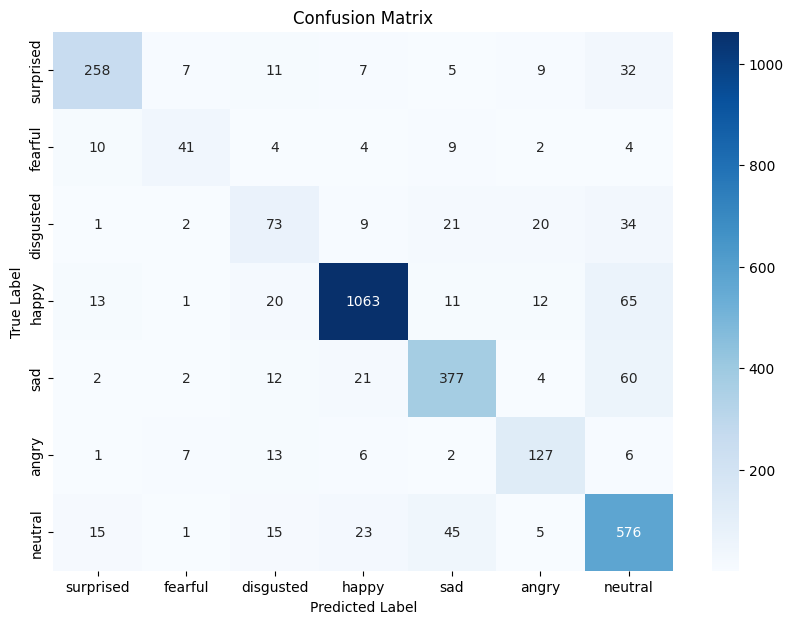

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
def test_model(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))



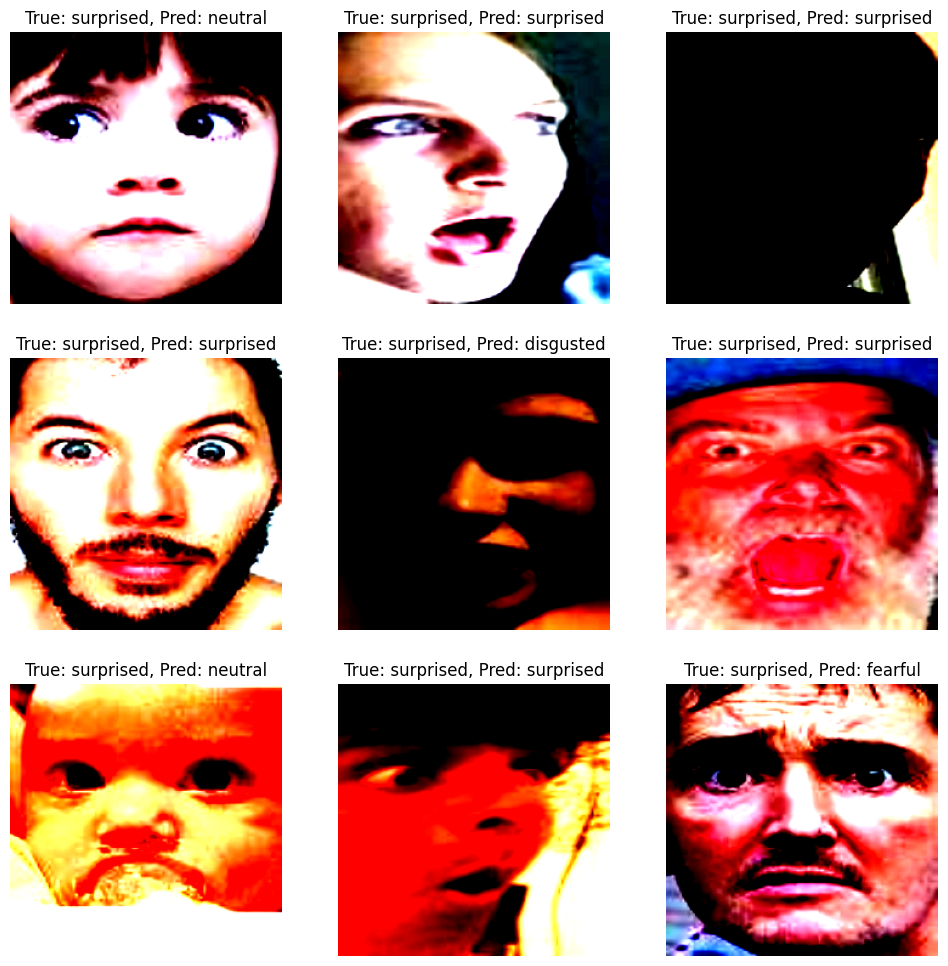

In [ ]:
# Visualize some test predictions
def visualize_predictions(model, data_loader, class_names, device):
    model.eval()
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            predictions = logits.argmax(dim=-1)

            imgs = imgs.cpu().numpy().transpose((0, 2, 3, 1))
            labels = labels.cpu().numpy()
            predictions = predictions.cpu().numpy()

            plt.figure(figsize=(12, 12))
            for i in range(min(len(imgs), 9)):
                plt.subplot(3, 3, i + 1)
                plt.imshow(imgs[i])
                plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[predictions[i]]}")
                plt.axis('off')
            plt.show()
            break

visualize_predictions(model, test_loader, class_names, device)

In [ ]:
# Test ResNet-50
test_model(model, test_loader, class_names)

Classification Report:
              precision    recall  f1-score   support

   surprised       0.86      0.78      0.82       329
     fearful       0.67      0.55      0.61        74
   disgusted       0.49      0.46      0.47       160
       happy       0.94      0.90      0.92      1185
         sad       0.80      0.79      0.80       478
       angry       0.71      0.78      0.74       162
     neutral       0.74      0.85      0.79       680

    accuracy                           0.82      3068
   macro avg       0.75      0.73      0.74      3068
weighted avg       0.82      0.82      0.82      3068



#VGG16

In [ ]:
# Pretrained VGG16 Model
class PretrainedVGG16(nn.Module):
    def __init__(self, num_classes=7):
        super(PretrainedVGG16, self).__init__()
        self.vgg16 = models.vgg16(weights='IMAGENET1K_V1')
        self.vgg16.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        return self.vgg16(x)

In [ ]:
# Initialize model, criterion, and optimizer for VGG16
vgg16_model = PretrainedVGG16(num_classes=7).to(device)
optimizer_vgg16 = optim.Adam(vgg16_model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_vgg16 = ReduceLROnPlateau(optimizer_vgg16, mode='min', factor=0.1, patience=5)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.3MB/s]


In [ ]:
# Training loop with early stopping
best_valid_acc = 0
epochs_no_improve = 0
early_stop = False
patience = 10  # Set your patience value

train_loss_history = []
train_acc_history = []
valid_loss_history = []
valid_acc_history = []

for epoch in range(n_epochs):
    if early_stop:
        print("Early stopping")
        break

    vgg16_model.train()
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):
        optimizer_vgg16.zero_grad()
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = vgg16_model(imgs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer_vgg16.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    vgg16_model.eval()
    valid_loss = []
    valid_accs = []

    with torch.no_grad():
        for batch in tqdm(valid_loader):
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = vgg16_model(imgs)
            loss = criterion(logits, labels)

            acc = (logits.argmax(dim=-1) == labels).float().mean()
            valid_loss.append(loss.item())
            valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)

    # Step the scheduler
    scheduler_vgg16.step(valid_loss)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(vgg16_model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        early_stop = True

    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

# Load the best model
vgg16_model.load_state_dict(torch.load('best_model.pth'))



  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 001/100] Train: loss=1.29118, acc=0.53023 | Valid: loss=1.01301, acc=0.64280


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 002/100] Train: loss=0.98936, acc=0.65153 | Valid: loss=0.88134, acc=0.68971


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 003/100] Train: loss=0.85928, acc=0.69486 | Valid: loss=0.87179, acc=0.69985


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 004/100] Train: loss=0.78335, acc=0.72241 | Valid: loss=0.75978, acc=0.72233


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 005/100] Train: loss=0.71649, acc=0.74888 | Valid: loss=0.72771, acc=0.74538


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 006/100] Train: loss=0.67605, acc=0.76038 | Valid: loss=0.70544, acc=0.74668


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 007/100] Train: loss=0.63051, acc=0.77650 | Valid: loss=0.68829, acc=0.75342


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 008/100] Train: loss=0.60370, acc=0.78580 | Valid: loss=0.66246, acc=0.77047


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 009/100] Train: loss=0.56636, acc=0.80198 | Valid: loss=0.66261, acc=0.76179


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 010/100] Train: loss=0.53913, acc=0.81209 | Valid: loss=0.64411, acc=0.77566


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 011/100] Train: loss=0.51020, acc=0.82332 | Valid: loss=0.65964, acc=0.77484


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 012/100] Train: loss=0.48687, acc=0.83160 | Valid: loss=0.63218, acc=0.78240


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 013/100] Train: loss=0.45957, acc=0.84080 | Valid: loss=0.65941, acc=0.77777


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 014/100] Train: loss=0.43746, acc=0.84708 | Valid: loss=0.61292, acc=0.78880


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 015/100] Train: loss=0.41715, acc=0.85101 | Valid: loss=0.64395, acc=0.78734


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 016/100] Train: loss=0.39147, acc=0.86411 | Valid: loss=0.62482, acc=0.79124


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 017/100] Train: loss=0.39234, acc=0.85946 | Valid: loss=0.63879, acc=0.77412


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 018/100] Train: loss=0.37326, acc=0.86706 | Valid: loss=0.65961, acc=0.78037


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 019/100] Train: loss=0.35985, acc=0.87429 | Valid: loss=0.69784, acc=0.78458


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 020/100] Train: loss=0.33276, acc=0.88240 | Valid: loss=0.60746, acc=0.78938


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 021/100] Train: loss=0.32295, acc=0.88830 | Valid: loss=0.68476, acc=0.79124


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 022/100] Train: loss=0.30685, acc=0.88881 | Valid: loss=0.64735, acc=0.79141


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 023/100] Train: loss=0.30502, acc=0.89336 | Valid: loss=0.66251, acc=0.79311


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 024/100] Train: loss=0.28902, acc=0.89726 | Valid: loss=0.68516, acc=0.78743


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 025/100] Train: loss=0.27858, acc=0.90018 | Valid: loss=0.72811, acc=0.77460


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 026/100] Train: loss=0.27502, acc=0.90347 | Valid: loss=0.65375, acc=0.79798


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 027/100] Train: loss=0.17371, acc=0.94201 | Valid: loss=0.62612, acc=0.81868


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 028/100] Train: loss=0.14255, acc=0.95168 | Valid: loss=0.65489, acc=0.81786


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 029/100] Train: loss=0.12428, acc=0.95976 | Valid: loss=0.65175, acc=0.81924


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 030/100] Train: loss=0.11289, acc=0.96074 | Valid: loss=0.66949, acc=0.81892


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 031/100] Train: loss=0.11214, acc=0.96091 | Valid: loss=0.70365, acc=0.81868


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 032/100] Train: loss=0.09854, acc=0.96590 | Valid: loss=0.72871, acc=0.81259


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 033/100] Train: loss=0.09629, acc=0.96719 | Valid: loss=0.71313, acc=0.81883


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 034/100] Train: loss=0.09304, acc=0.96936 | Valid: loss=0.66836, acc=0.82476


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 035/100] Train: loss=0.08226, acc=0.97248 | Valid: loss=0.71690, acc=0.82501


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 036/100] Train: loss=0.07983, acc=0.97425 | Valid: loss=0.73948, acc=0.81356


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 037/100] Train: loss=0.08554, acc=0.97099 | Valid: loss=0.72643, acc=0.82339


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 038/100] Train: loss=0.08080, acc=0.97241 | Valid: loss=0.70871, acc=0.82046


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 039/100] Train: loss=0.08648, acc=0.97072 | Valid: loss=0.73771, acc=0.82233


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 040/100] Train: loss=0.08204, acc=0.97140 | Valid: loss=0.75763, acc=0.81608


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 041/100] Train: loss=0.08014, acc=0.97347 | Valid: loss=0.70441, acc=0.82152


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 042/100] Train: loss=0.07638, acc=0.97269 | Valid: loss=0.71190, acc=0.82939


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 043/100] Train: loss=0.07765, acc=0.97428 | Valid: loss=0.73599, acc=0.82111


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 044/100] Train: loss=0.08462, acc=0.97106 | Valid: loss=0.74372, acc=0.82411


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 045/100] Train: loss=0.08216, acc=0.97218 | Valid: loss=0.72939, acc=0.82452


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 046/100] Train: loss=0.08438, acc=0.96994 | Valid: loss=0.73631, acc=0.82127


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 047/100] Train: loss=0.08340, acc=0.97187 | Valid: loss=0.71101, acc=0.83069


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 048/100] Train: loss=0.08904, acc=0.97170 | Valid: loss=0.74268, acc=0.82452


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 049/100] Train: loss=0.08469, acc=0.97275 | Valid: loss=0.72323, acc=0.81649


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 050/100] Train: loss=0.08296, acc=0.97102 | Valid: loss=0.75906, acc=0.82330


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 051/100] Train: loss=0.08215, acc=0.97323 | Valid: loss=0.73436, acc=0.81405


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 052/100] Train: loss=0.07886, acc=0.97343 | Valid: loss=0.69990, acc=0.81883


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 053/100] Train: loss=0.08534, acc=0.97058 | Valid: loss=0.70484, acc=0.82655


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 054/100] Train: loss=0.08356, acc=0.97211 | Valid: loss=0.75267, acc=0.81705


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 055/100] Train: loss=0.08010, acc=0.97269 | Valid: loss=0.71814, acc=0.82330


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 056/100] Train: loss=0.08382, acc=0.97031 | Valid: loss=0.74384, acc=0.82695


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 057/100] Train: loss=0.08094, acc=0.97323 | Valid: loss=0.72122, acc=0.82086
Early stopping


<All keys matched successfully>

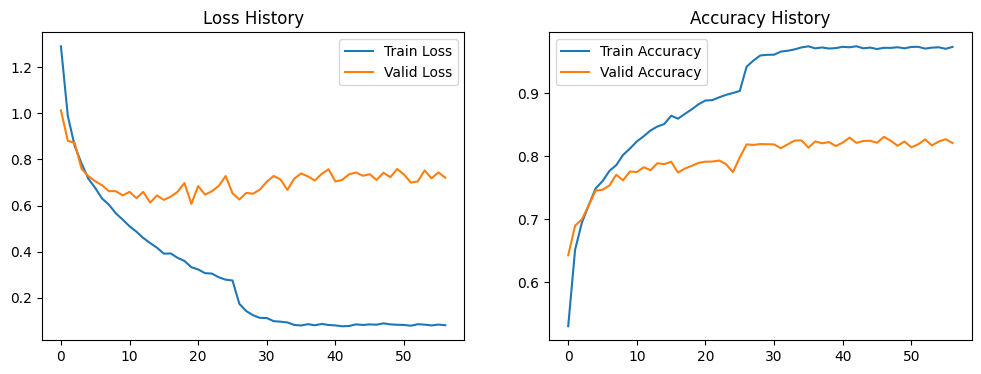

In [ ]:
# Plotting training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Valid Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(valid_acc_history, label='Valid Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.show()

In [ ]:
# Evaluate on the test set and compute metrics
vgg16_model.eval()
test_loss = []
test_accs = []
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = vgg16_model(imgs)
        loss = criterion(logits, labels)

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        test_loss.append(loss.item())
        test_accs.append(acc.item())

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(logits.argmax(dim=-1).cpu().numpy())

test_loss = sum(test_loss) / len(test_loss)
test_acc = sum(test_accs) / len(test_accs)

print(f"Test: loss={test_loss:.5f}, acc={test_acc:.5f}")


  0%|          | 0/96 [00:00<?, ?it/s]

Test: loss=0.70771, acc=0.83659


In [ ]:
# Print test loss and accuracy
print(f"Test Loss: {test_loss:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")

Test Loss: 0.70771
Test Accuracy: 0.83659


In [ ]:
# Generate predictions and true labels
y_true = []
y_pred = []

vgg16_model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = vgg16_model(imgs)
        predictions = logits.argmax(dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

  0%|          | 0/96 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

   surprised       0.83      0.88      0.85       329
     fearful       0.67      0.54      0.60        74
   disgusted       0.52      0.54      0.53       160
       happy       0.95      0.91      0.93      1185
         sad       0.79      0.81      0.80       478
       angry       0.75      0.78      0.77       162
     neutral       0.80      0.81      0.81       680

    accuracy                           0.84      3068
   macro avg       0.76      0.75      0.76      3068
weighted avg       0.84      0.84      0.84      3068



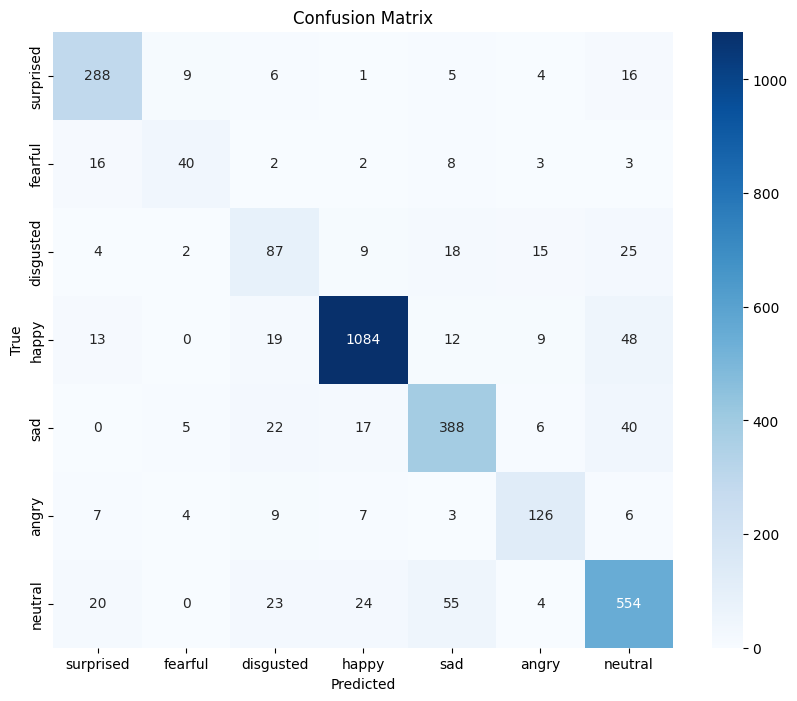

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Initialize lists to store true labels and predicted probabilities
y_true = []
y_pred_proba = []

vgg16_model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        logits = vgg16_model(imgs)
        probs = torch.softmax(logits, dim=1)  # Get probabilities using softmax
        y_true.extend(labels.cpu().numpy())
        y_pred_proba.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Binarize the true labels for AUC computation
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

# Calculate AUC for each class
roc_auc = roc_auc_score(y_true_bin, y_pred_proba, average='macro', multi_class='ovr')
print(f"AUC: {roc_auc:.4f}")

  0%|          | 0/96 [00:00<?, ?it/s]

AUC: 0.9655


In [ ]:
# Generate predictions from the probabilities
y_pred = np.argmax(y_pred_proba, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

   surprised       0.83      0.88      0.85       329
     fearful       0.67      0.54      0.60        74
   disgusted       0.52      0.54      0.53       160
       happy       0.95      0.91      0.93      1185
         sad       0.79      0.81      0.80       478
       angry       0.75      0.78      0.77       162
     neutral       0.80      0.81      0.81       680

    accuracy                           0.84      3068
   macro avg       0.76      0.75      0.76      3068
weighted avg       0.84      0.84      0.84      3068



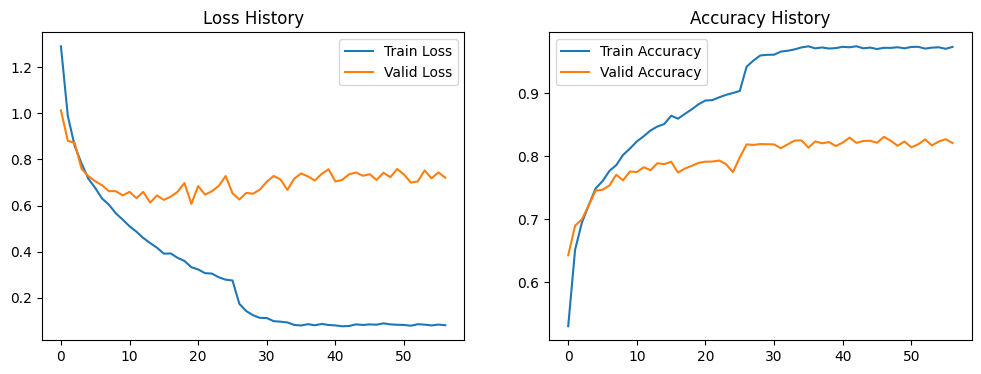

In [ ]:
# Plotting training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Valid Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(valid_acc_history, label='Valid Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.show()

In [ ]:
# Evaluate on the test set
vgg16_model.eval()
test_loss = []
test_accs = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = vgg16_model(imgs)
        loss = criterion(logits, labels)

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        test_loss.append(loss.item())
        test_accs.append(acc.item())

test_loss = sum(test_loss) / len(test_loss)
test_acc = sum(test_accs) / len(test_accs)

print(f"Test: loss={test_loss:.5f}, acc={test_acc:.5f}")


  0%|          | 0/96 [00:00<?, ?it/s]

Test: loss=0.70771, acc=0.83659


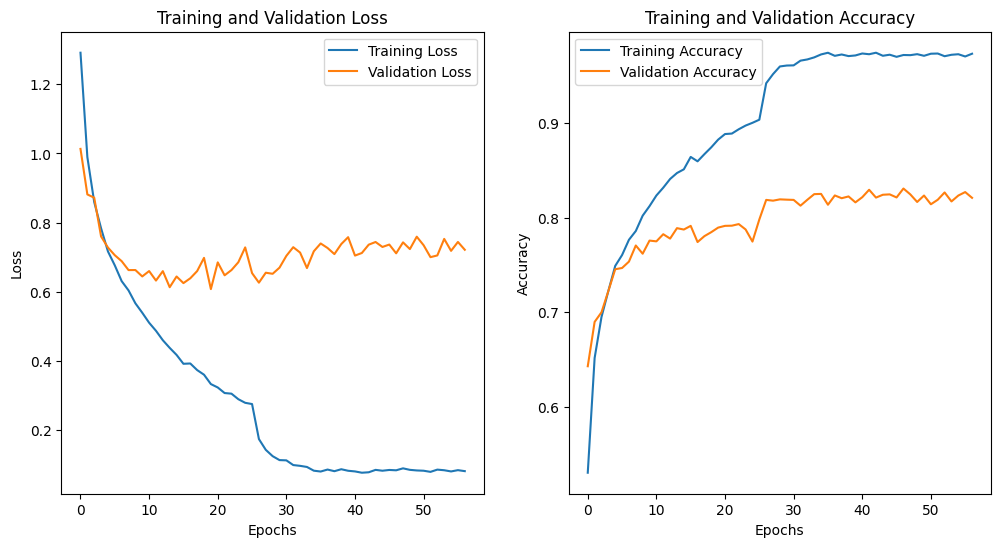

In [ ]:
# Plotting the loss
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(valid_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# load best model weights
vgg16_model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
vgg16_model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = vgg16_model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/96 [00:00<?, ?it/s]

Test accuracy 0.8365885615348816


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Print test loss and accuracy
print(f"Test Loss: {test_loss:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")

Test Loss: 0.70771
Test Accuracy: 0.83659


In [ ]:
# Generate predictions and true labels
y_true = []
y_pred = []

vgg16_model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = vgg16_model(imgs)
        predictions = logits.argmax(dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

  0%|          | 0/96 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

   surprised       0.83      0.88      0.85       329
     fearful       0.67      0.54      0.60        74
   disgusted       0.52      0.54      0.53       160
       happy       0.95      0.91      0.93      1185
         sad       0.79      0.81      0.80       478
       angry       0.75      0.78      0.77       162
     neutral       0.80      0.81      0.81       680

    accuracy                           0.84      3068
   macro avg       0.76      0.75      0.76      3068
weighted avg       0.84      0.84      0.84      3068



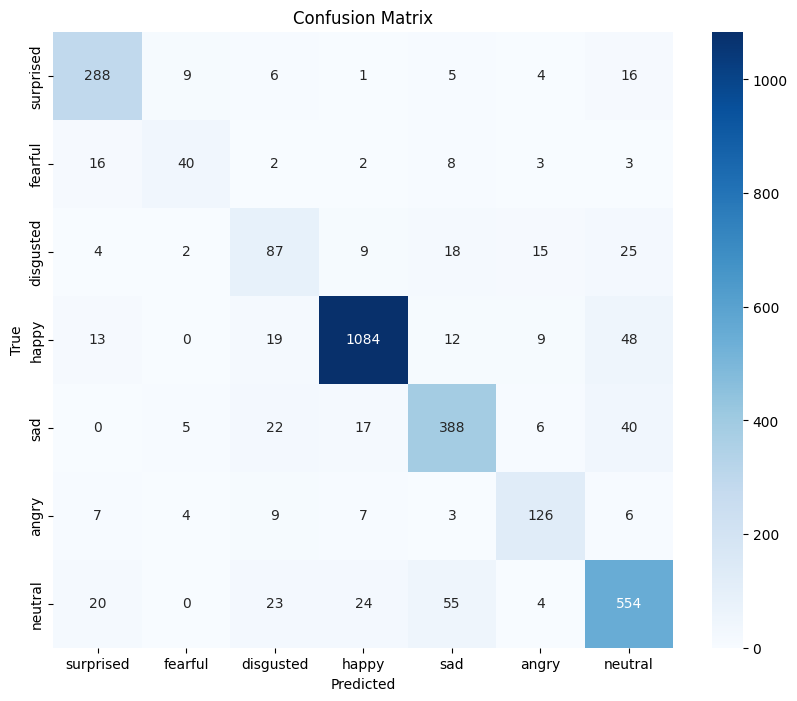

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


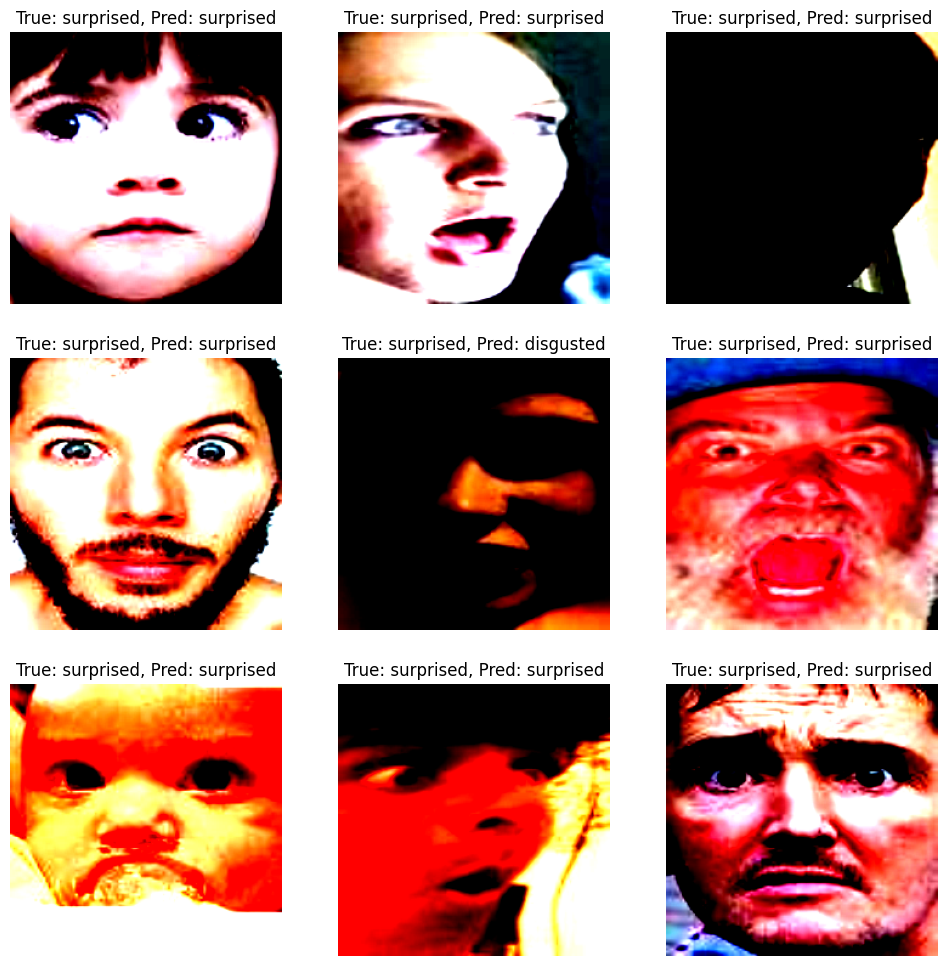

In [ ]:
# Visualize some test predictions
def visualize_predictions(vgg16_model, data_loader, class_names, device):
    vgg16_model.eval()
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = vgg16_model(imgs)
            predictions = logits.argmax(dim=-1)

            imgs = imgs.cpu().numpy().transpose((0, 2, 3, 1))
            labels = labels.cpu().numpy()
            predictions = predictions.cpu().numpy()

            plt.figure(figsize=(12, 12))
            for i in range(min(len(imgs), 9)):
                plt.subplot(3, 3, i + 1)
                plt.imshow(imgs[i])
                plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[predictions[i]]}")
                plt.axis('off')
            plt.show()
            break

visualize_predictions(vgg16_model, test_loader, class_names, device)

#EFFICIENTNET_B3

In [ ]:
# Pretrained EfficientNet-B3 Model
class PretrainedEfficientNetB3(nn.Module):
    def __init__(self, num_classes=7):
        super(PretrainedEfficientNetB3, self).__init__()
        self.efficientnetb3 = models.efficientnet_b3(weights='IMAGENET1K_V1')
        self.efficientnetb3.classifier[1] = nn.Linear(self.efficientnetb3.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.efficientnetb3(x)

In [ ]:
# Initialize model, criterion, and optimizer for EfficientNet-B3
efficientnetb3_model = PretrainedEfficientNetB3(num_classes=7).to(device)
optimizer_efficientnetb3 = optim.Adam(efficientnetb3_model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_efficientnetb3 = ReduceLROnPlateau(optimizer_efficientnetb3, mode='min', factor=0.1, patience=5)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 158MB/s]


In [ ]:
# Training loop with early stopping
best_valid_acc = 0
epochs_no_improve = 0
early_stop = False
patience = 10  # Set your patience value

train_loss_history = []
train_acc_history = []
valid_loss_history = []
valid_acc_history = []

for epoch in range(n_epochs):
    if early_stop:
        print("Early stopping")
        break

    efficientnetb3_model.train()
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):
        optimizer_efficientnetb3.zero_grad()
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = efficientnetb3_model(imgs)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer_efficientnetb3.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    efficientnetb3_model.eval()
    valid_loss = []
    valid_accs = []

    with torch.no_grad():
        for batch in tqdm(valid_loader):
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = efficientnetb3_model(imgs)
            loss = criterion(logits, labels)

            acc = (logits.argmax(dim=-1) == labels).float().mean()
            valid_loss.append(loss.item())
            valid_accs.append(acc.item())

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)

    # Step the scheduler
    scheduler_efficientnetb3.step(valid_loss)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(efficientnetb3_model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        early_stop = True

    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

# Load the best model
efficientnetb3_model.load_state_dict(torch.load('best_model.pth'))

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 001/100] Train: loss=1.39682, acc=0.49427 | Valid: loss=1.04013, acc=0.62876


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 002/100] Train: loss=0.96311, acc=0.65452 | Valid: loss=0.79953, acc=0.71340


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 003/100] Train: loss=0.76903, acc=0.72713 | Valid: loss=0.69779, acc=0.74912


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 004/100] Train: loss=0.66204, acc=0.76853 | Valid: loss=0.64282, acc=0.76803


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 005/100] Train: loss=0.58465, acc=0.79289 | Valid: loss=0.60647, acc=0.78670


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 006/100] Train: loss=0.50493, acc=0.81949 | Valid: loss=0.59305, acc=0.79498


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 007/100] Train: loss=0.45427, acc=0.83791 | Valid: loss=0.57783, acc=0.80025


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 008/100] Train: loss=0.42088, acc=0.84914 | Valid: loss=0.55235, acc=0.81568


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 009/100] Train: loss=0.37053, acc=0.87001 | Valid: loss=0.57130, acc=0.80909


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 010/100] Train: loss=0.33436, acc=0.88145 | Valid: loss=0.58200, acc=0.81494


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 011/100] Train: loss=0.29920, acc=0.88796 | Valid: loss=0.56016, acc=0.82558


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 012/100] Train: loss=0.26908, acc=0.90510 | Valid: loss=0.61085, acc=0.80553


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 013/100] Train: loss=0.23520, acc=0.91816 | Valid: loss=0.61730, acc=0.80991


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 014/100] Train: loss=0.21762, acc=0.92352 | Valid: loss=0.61464, acc=0.81259


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 015/100] Train: loss=0.17683, acc=0.93984 | Valid: loss=0.63939, acc=0.81559


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 016/100] Train: loss=0.15439, acc=0.94849 | Valid: loss=0.60120, acc=0.82776


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 017/100] Train: loss=0.14801, acc=0.94829 | Valid: loss=0.62376, acc=0.82224


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 018/100] Train: loss=0.14454, acc=0.95121 | Valid: loss=0.59918, acc=0.82289


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 019/100] Train: loss=0.14094, acc=0.95263 | Valid: loss=0.62855, acc=0.82370


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 020/100] Train: loss=0.13813, acc=0.95416 | Valid: loss=0.62661, acc=0.82395


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 021/100] Train: loss=0.12451, acc=0.95881 | Valid: loss=0.63489, acc=0.81933


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 022/100] Train: loss=0.13080, acc=0.95552 | Valid: loss=0.60451, acc=0.83247


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 023/100] Train: loss=0.12592, acc=0.95820 | Valid: loss=0.62981, acc=0.82542


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 024/100] Train: loss=0.12734, acc=0.95609 | Valid: loss=0.63835, acc=0.81714


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 025/100] Train: loss=0.12494, acc=0.95911 | Valid: loss=0.62937, acc=0.82833


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 026/100] Train: loss=0.12964, acc=0.95745 | Valid: loss=0.60636, acc=0.83191


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 027/100] Train: loss=0.12733, acc=0.95694 | Valid: loss=0.61209, acc=0.82055


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 028/100] Train: loss=0.12407, acc=0.95721 | Valid: loss=0.63371, acc=0.83076


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 029/100] Train: loss=0.12162, acc=0.96207 | Valid: loss=0.61464, acc=0.83466


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 030/100] Train: loss=0.11838, acc=0.95867 | Valid: loss=0.60542, acc=0.83020


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 031/100] Train: loss=0.13168, acc=0.95606 | Valid: loss=0.60720, acc=0.82355


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 032/100] Train: loss=0.13141, acc=0.95426 | Valid: loss=0.64501, acc=0.82086


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 033/100] Train: loss=0.12865, acc=0.95793 | Valid: loss=0.61311, acc=0.82233


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 034/100] Train: loss=0.12918, acc=0.95657 | Valid: loss=0.61549, acc=0.81755


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 035/100] Train: loss=0.12992, acc=0.95558 | Valid: loss=0.61964, acc=0.82249


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 036/100] Train: loss=0.12397, acc=0.95830 | Valid: loss=0.59945, acc=0.82289


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 037/100] Train: loss=0.12299, acc=0.95976 | Valid: loss=0.60748, acc=0.82111


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 038/100] Train: loss=0.12802, acc=0.95592 | Valid: loss=0.60747, acc=0.83166


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

[Epoch: 039/100] Train: loss=0.12446, acc=0.95765 | Valid: loss=0.63610, acc=0.83078
Early stopping


<All keys matched successfully>

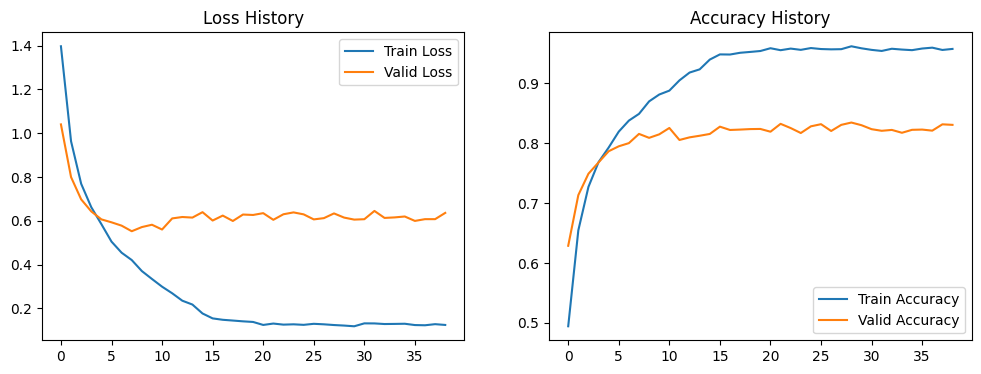

In [ ]:
# Plotting training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Valid Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(valid_acc_history, label='Valid Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.show()

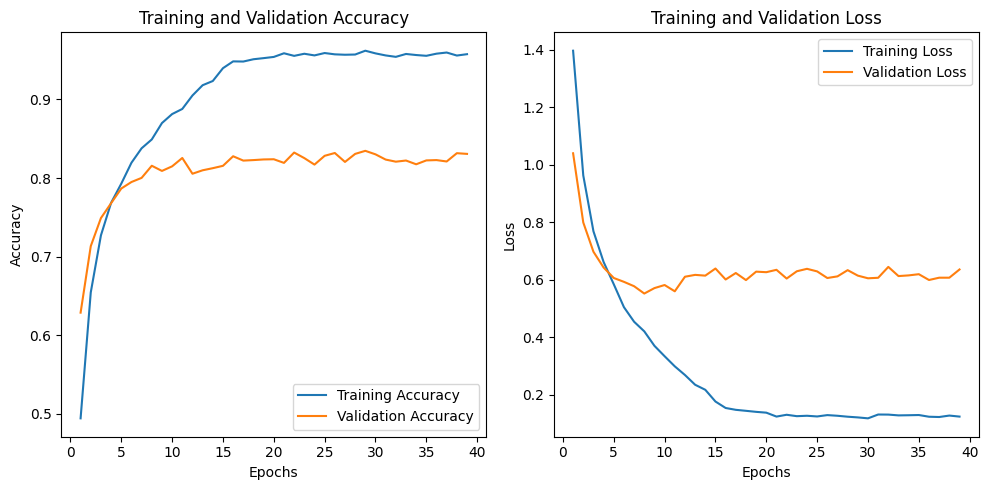

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Training Accuracy')
plt.plot(range(1, len(valid_acc_history) + 1), valid_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate on the test set and compute metrics
efficientnetb3_model.eval()
test_loss = []
test_accs = []
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = efficientnetb3_model(imgs)
        loss = criterion(logits, labels)

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        test_loss.append(loss.item())
        test_accs.append(acc.item())

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(logits.argmax(dim=-1).cpu().numpy())

test_loss = sum(test_loss) / len(test_loss)
test_acc = sum(test_accs) / len(test_accs)

print(f"Test: loss={test_loss:.5f}, acc={test_acc:.5f}")

  0%|          | 0/96 [00:00<?, ?it/s]

Test: loss=0.57478, acc=0.82636


In [ ]:
# Print test loss and accuracy
print(f"Test Loss: {test_loss:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")

Test Loss: 0.57478
Test Accuracy: 0.82636


In [ ]:
# Generate predictions and true labels
y_true = []
y_pred = []

efficientnetb3_model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = efficientnetb3_model(imgs)
        predictions = logits.argmax(dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

  0%|          | 0/96 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

   surprised       0.80      0.86      0.83       329
     fearful       0.74      0.57      0.64        74
   disgusted       0.54      0.59      0.57       160
       happy       0.95      0.89      0.92      1185
         sad       0.80      0.81      0.81       478
       angry       0.69      0.81      0.74       162
     neutral       0.78      0.80      0.79       680

    accuracy                           0.83      3068
   macro avg       0.76      0.76      0.76      3068
weighted avg       0.83      0.83      0.83      3068



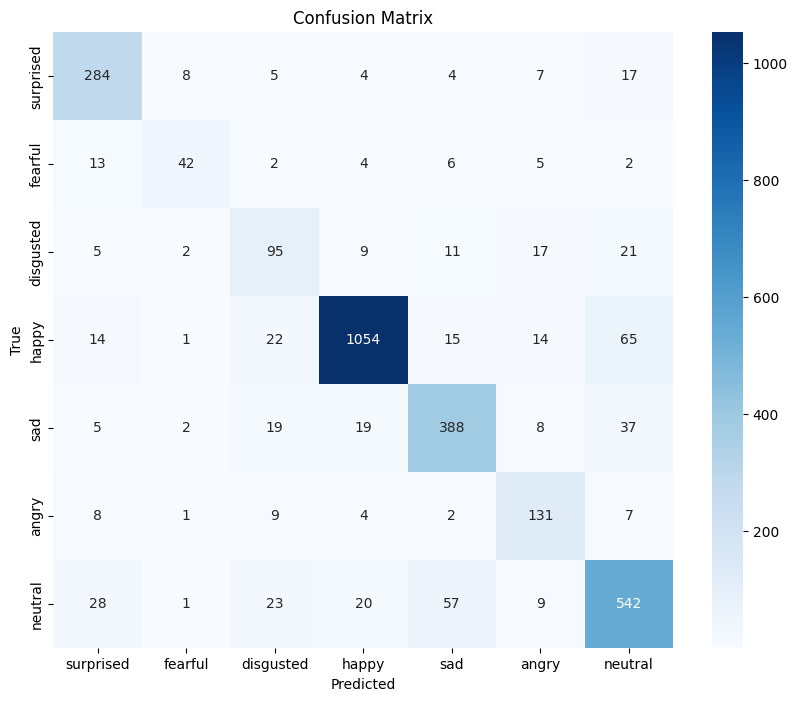

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Initialize lists to store true labels and predicted probabilities
y_true = []
y_pred_proba = []

efficientnetb3_model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        logits = efficientnetb3_model(imgs)
        probs = torch.softmax(logits, dim=1)  # Get probabilities using softmax
        y_true.extend(labels.cpu().numpy())
        y_pred_proba.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Binarize the true labels for AUC computation
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

# Calculate AUC for each class
roc_auc = roc_auc_score(y_true_bin, y_pred_proba, average='macro', multi_class='ovr')
print(f"AUC: {roc_auc:.4f}")

  0%|          | 0/96 [00:00<?, ?it/s]

AUC: 0.9660


In [ ]:
# Generate predictions from the probabilities
y_pred = np.argmax(y_pred_proba, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

   surprised       0.80      0.86      0.83       329
     fearful       0.74      0.57      0.64        74
   disgusted       0.54      0.59      0.57       160
       happy       0.95      0.89      0.92      1185
         sad       0.80      0.81      0.81       478
       angry       0.69      0.81      0.74       162
     neutral       0.78      0.80      0.79       680

    accuracy                           0.83      3068
   macro avg       0.76      0.76      0.76      3068
weighted avg       0.83      0.83      0.83      3068



In [ ]:
# Evaluate on the test set
efficientnetb3_model.eval()
test_loss = []
test_accs = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = efficientnetb3_model(imgs)
        loss = criterion(logits, labels)

        acc = (logits.argmax(dim=-1) == labels).float().mean()
        test_loss.append(loss.item())
        test_accs.append(acc.item())

test_loss = sum(test_loss) / len(test_loss)
test_acc = sum(test_accs) / len(test_accs)

print(f"Test: loss={test_loss:.5f}, acc={test_acc:.5f}")


  0%|          | 0/96 [00:00<?, ?it/s]

Test: loss=0.57478, acc=0.82636


In [ ]:
# load best model weights
efficientnetb3_model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
efficientnetb3_model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = efficientnetb3_model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/96 [00:00<?, ?it/s]

Test accuracy 0.8263579607009888


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Print test loss and accuracy
print(f"Test Loss: {test_loss:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")

Test Loss: 0.57478
Test Accuracy: 0.82636


In [ ]:
# Generate predictions and true labels
y_true = []
y_pred = []

efficientnetb3_model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = efficientnetb3_model(imgs)
        predictions = logits.argmax(dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

  0%|          | 0/96 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

   surprised       0.80      0.86      0.83       329
     fearful       0.74      0.57      0.64        74
   disgusted       0.54      0.59      0.57       160
       happy       0.95      0.89      0.92      1185
         sad       0.80      0.81      0.81       478
       angry       0.69      0.81      0.74       162
     neutral       0.78      0.80      0.79       680

    accuracy                           0.83      3068
   macro avg       0.76      0.76      0.76      3068
weighted avg       0.83      0.83      0.83      3068



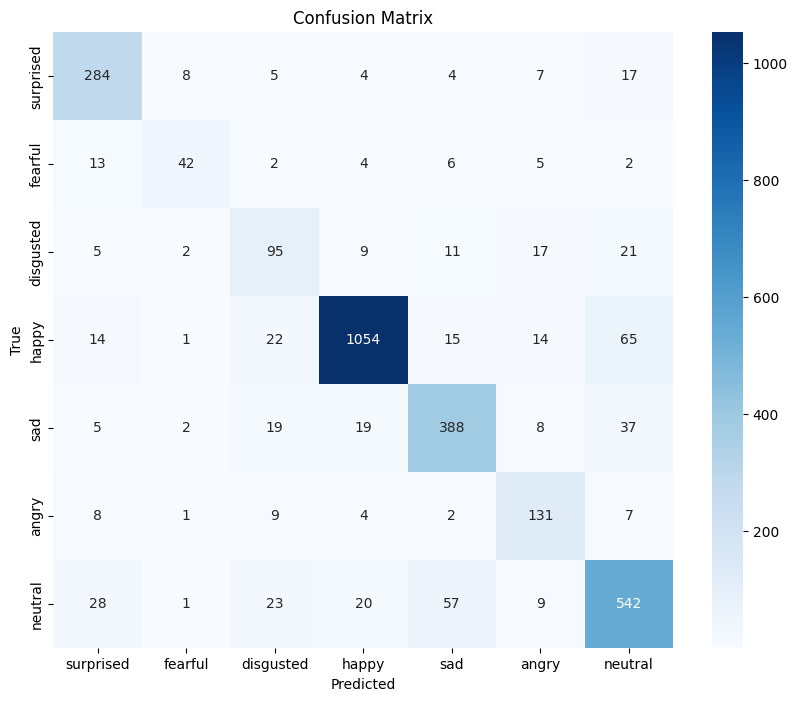

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


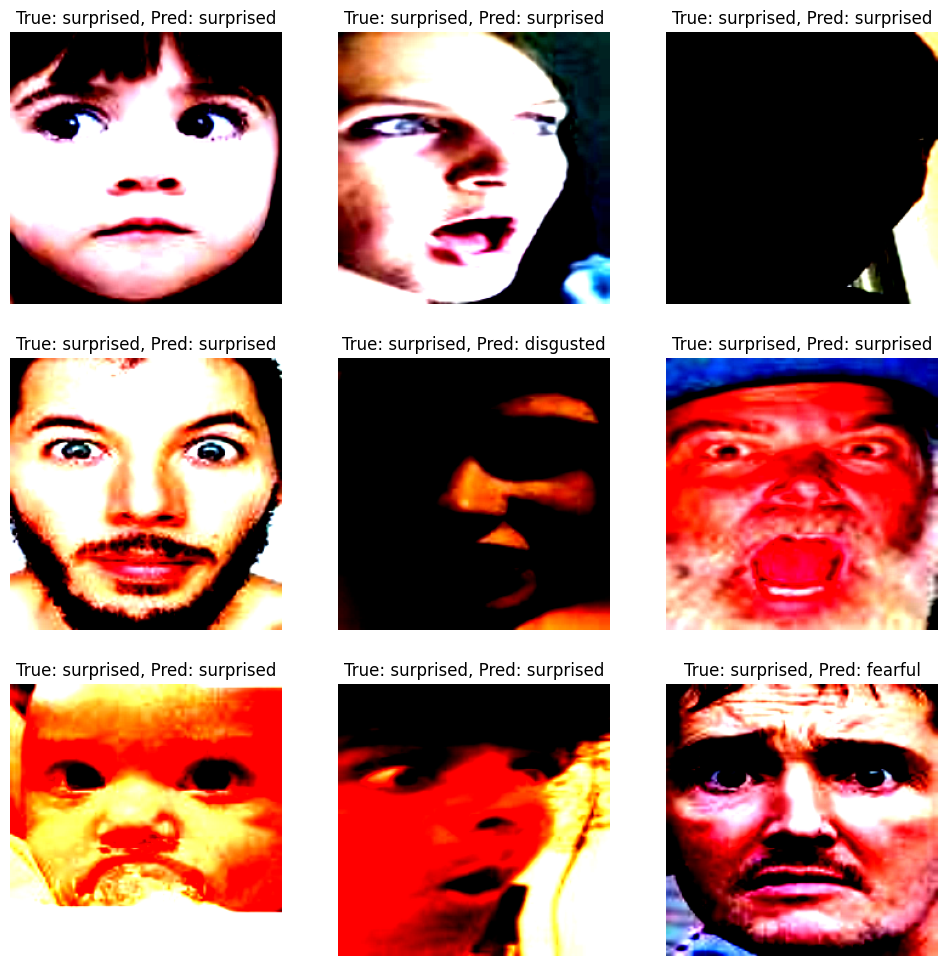

In [ ]:
# Visualize some test predictions
def visualize_predictions(efficientnetb3_model, data_loader, class_names, device):
    efficientnetb3_model.eval()
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = efficientnetb3_model(imgs)
            predictions = logits.argmax(dim=-1)

            imgs = imgs.cpu().numpy().transpose((0, 2, 3, 1))
            labels = labels.cpu().numpy()
            predictions = predictions.cpu().numpy()

            plt.figure(figsize=(12, 12))
            for i in range(min(len(imgs), 9)):
                plt.subplot(3, 3, i + 1)
                plt.imshow(imgs[i])
                plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[predictions[i]]}")
                plt.axis('off')
            plt.show()
            break

visualize_predictions(efficientnetb3_model, test_loader, class_names, device)

#SAVE THE BEST MODEL

In [ ]:
import streamlit as st
import torch
import torch.nn as nn
from torchvision import transforms, models
import cv2
from PIL import Image
import numpy as np

In [ ]:

# Define the class names
class_names = ['surprised', 'fearful', 'disgusted', 'happy', 'sad', 'angry', 'neutral']

# Load the pretrained model
class PretrainedResNet50(nn.Module):
    def __init__(self, num_classes=7):
        super(PretrainedResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
model = PretrainedResNet50(num_classes=7)
model.load_state_dict(torch.load('best_resnet50_model.pth'))
model.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict(image):
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        return class_names[predicted[0]]

# Streamlit app
st.title("Facial Emotion Recognition")

# Option to choose between image upload and webcam
option = st.selectbox('Choose input method:', ('Upload Image', 'Use Webcam'))

if option == 'Upload Image':
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])
    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption='Uploaded Image.', use_column_width=True)
        st.write("")
        st.write("Classifying...")

        label = predict(image)
        st.write(f"Prediction: {label}")

elif option == 'Use Webcam':
    st.write("This app uses your webcam to detect facial expressions in real-time.")
    run = st.checkbox('Run')

    FRAME_WINDOW = st.image([])

    cap = cv2.VideoCapture(0)

    while run:
        ret, frame = cap.read()
        if not ret:
            st.write("Could not access webcam.")
            break

        # Convert the frame to RGB format
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert the frame to PIL Image
        pil_img = Image.fromarray(frame_rgb)

        # Make prediction
        label = predict(pil_img)

        # Display the label on the frame
        cv2.putText(frame_rgb, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

        # Update the streamlit frame
        FRAME_WINDOW.image(frame_rgb)

    cap.release()


2024-08-10 23:01:14.914 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-08-10 23:01:14.915 Session state does not function when running a script without `streamlit run`
